<a href="https://colab.research.google.com/github/JuanM-GG/maestria/blob/main/ml-lote/ml_inhibition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font color="Teal" face="Arial">
  <h1 align="center"><i>Método de Euler combinado con redes neuronales para simular fermentaciones en biorreactor</i></h1>
  </font>
  <font color="Black" face="Comic Sans MS,arial">
  <h5 align="center"><i>I.B. Juan Manuel Gutiérrez García</i></h5>
  <h5 align="center"><i>correo: 2032390x@umich.mx</i></h5>
  </font>

### Intalar los módulos que se necesitarán

In [ ]:
pip install pyDOE

In [ ]:
pip install torchdyn

### Importar los módulos

In [3]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint

# 1. Generación de datos a través de simulaciones de modelo mecanístico

#### Modelo mecanístico de la fermentación en biorreactor

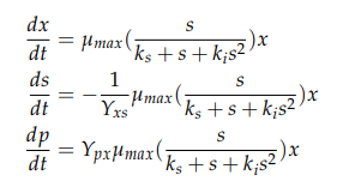

In [4]:
# modelo de biorreactor
def f(t, x):
    b = x[..., 0]
    s = x[..., 1]
    p = x[..., 2]

    # parámetros cinéticos
    mu = 1.2 # 1/h
    ks = 280 # g/L
    Yxs = 0.2 
    Ypx = 4 
    ki = 0.3

    # balances de masa
    db = mu*(s / (ks + s + ki*s**2))*b 
    ds = -1/Yxs*mu*(s / (ks + s + ki*s**2))*b 
    dp = Ypx*mu*(s / (ks + s + ki*s**2))*b

    return torch.stack((db, ds, dp), dim=-1)

### Generar datos de entrenamiento (entradas)

Cada modelo se entrena en 100 trayectorias, cada una de las cuales consta de dos muestras; el estado inicial y el estado un paso hacia el futuro

In [5]:
# condiciones iniciales para el entrenamiento
num_trayectorias_entrenamiento = 100
# datos 'reales' para el entrenamiento (condiciones iniciales)
x0_train = (
    torch.tensor(lhs(3, num_trayectorias_entrenamiento), device='cpu') 
) 
# rangos de entrenamiento
x0_train[:,0] = x0_train[:,0] * 10 + 0.2 # biomasa (0.2-10.2)
x0_train[:,1] = x0_train[:,1]* 40 # sustrato (0-40)
x0_train[:,2] = x0_train[:,2]* 40 # producto (0-40)
print(x0_train[0:5,:]) 
print(x0_train.shape)

tensor([[ 4.7961,  5.6142, 14.5588],
        [ 1.0774,  9.2093, 12.4493],
        [ 6.7244, 27.3734,  1.6731],
        [10.0674, 11.4824, 25.8381],
        [ 9.9822,  4.6404, 31.9937]], dtype=torch.float64)
torch.Size([100, 3])


### Generamos los datos de validación (entradas)

In [6]:
# condiciones iniciales para la validación de la red
num_trayectorias_validacion = 10
x0_validate = (
    torch.tensor(lhs(3, num_trayectorias_validacion), device='cpu') 
)
# rangos de entrenamiento
x0_validate[:,0] = x0_validate[:,0] + 0.2 # biomasa (0.2-1.2)
x0_validate[:,1] = x0_validate[:,1]* 20 + 20 # sustrato (20-40)
x0_validate[:,2] = x0_validate[:,2]* 0 # producto (0)
print(x0_validate[0:5,:]) 
print(x0_validate.shape)

tensor([[ 0.5867, 35.1900,  0.0000],
        [ 0.9075, 27.1885,  0.0000],
        [ 0.3561, 23.9701,  0.0000],
        [ 1.0793, 31.4890,  0.0000],
        [ 0.4825, 32.4101,  0.0000]], dtype=torch.float64)
torch.Size([10, 3])


### Definir tamaño de paso para el método de Euler y el tiempo de simulación

In [7]:
#@title tiempo de entrenamiento
# son trayectorias cortas de una hora 
# (tomar muestras cada hora es algo razonable)
step_size_train = 1
ε = 1e-10 # solo para asegurar que se incluye el tiempo final
t_span_train = torch.arange(
    0.0, 
    1 + ε,
    step_size_train
)

# tiempo para la validación, esto se va a comparar con la simulación del modelo mecanistico
t_span_validate = torch.arange(
    0.0,
    60 + ε,
    step_size_train
)

### Generamos los datos de entrenamiento (salida)

In [8]:
# datos de salida 'reales' para el entrenamiento 
_, x_train = odeint(f, x0_train, t_span_train, solver="rk4")
x_true = x_train
print(x_true.shape) # The first tensor are the initial conditions (x0_train)

torch.Size([2, 100, 3])


In [9]:
torch.all(x0_train == x_true[0])

tensor(True)

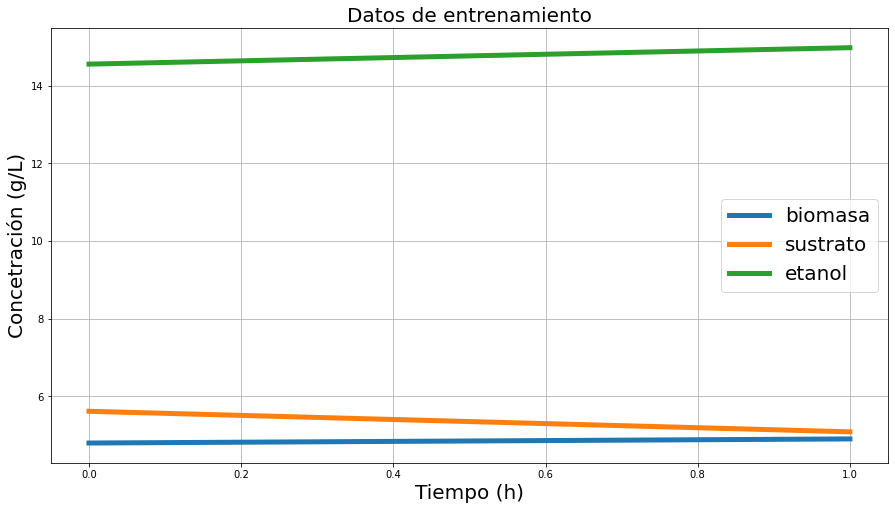

In [10]:
# en la trayectoría número 0 así cambia la biomasa, el sustrato y el producto en un intervalo de 1 hora
trayectoria = 0
plt.figure(figsize=(15,8))
plt.plot(x_true[:, trayectoria, 0], label='biomasa', linewidth = 5)
plt.plot(x_true[:, trayectoria, 1], label='sustrato', linewidth = 5)
plt.plot(x_true[:, trayectoria, 2], label='etanol', linewidth = 5)
plt.grid()
plt.title("Datos de entrenamiento", size = 20)
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.legend(fontsize = 20)

### Generamos los datos de validación (salida)

In [11]:
 # obtenemos las trayectorias x(t) para las condiciones iniciales de los 
# datos de validación, esto también se considera 'real'
_, x_validate = odeint(f, x0_validate, t_span_validate, solver="rk4")
print(x_validate.shape) # 61 observaciones en la trayectoria

torch.Size([61, 10, 3])


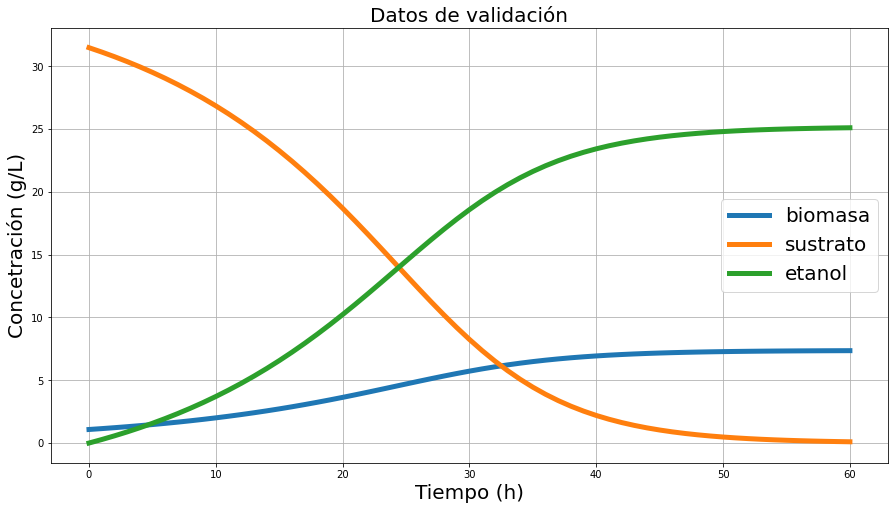

In [12]:
# trayectoría de validación 'real' número 3
trayectoria = 3
plt.figure(figsize=(15,8))
plt.plot(x_validate[:, trayectoria, 0], label = 'biomasa', linewidth = 5)
plt.plot(x_validate[:, trayectoria, 1], label = 'sustrato', linewidth = 5)
plt.plot(x_validate[:, trayectoria, 2], label = 'etanol', linewidth = 5)
plt.grid()
plt.title("Datos de validación", size = 20)
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.legend(fontsize = 20)



<font color="Teal" face="Arial">
  <h1 align="center"><i>TIME-STEPPER MODELS</i></h1>
</font>

 1.  Un time-stepper debe ser capaz de producir simulaciones precisas para diferentes condiciones iniciales

 2. Las predicciones futuras de un time-stepper dependen de predicciones pasadas

 3. Se utilizan varias trayectorias cortas para entrenar la red.

## Función objetivo

El objetivo de entrenar un time-stepper es encontrar un modelo que minimice la discrepancia entre el estado real y el predicho, para cada punto utilizado para el entrenamiento. Un enfoque simple para hacerlo es minimizar el error de un solo paso



$$
 J(\vec{w}, \vec{b}) = \sum_{k=0}^{N-1} |\tilde{x_k} - x_k|
$$

donde $\tilde{x}_{k+1} = \tilde{x}_k + h_k * N(\tilde{x}_k)$ y $\tilde{x}_0 = x_0$

## Red Neuronal Artificial 




In [13]:
##################### red neuronal ##########################
layers = []
# Capa de entrada
layers.append(nn.Linear(3, 32))
for _ in range(8):
    # Capas escodidas
    layers.append(nn.Linear(32,32))
    # Función de activación
    layers.append(nn.Softplus())

# Capa de salida
layers.append(nn.Linear(32, 3))

# Crear la red de forma secuencial
net = nn.Sequential(*layers)
net.to('cpu').double()

# Inicializar los parámetros a valores aleatorios
for m in net.modules():
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

## Entrenamiento de la Red 

In [14]:
# Algoritmo de optimización
opt = Adam(net.parameters())

In [15]:
# Entrenamiento de la red
losses = []

for _ in tqdm(range(400)):

    _, x_pred_train = odeint(
        lambda t, x: net(x), x0_train, t_span_train, solver='euler'
    )
    loss = 100000*mse_loss(x_pred_train, x_train)
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

100%|██████████| 400/400 [00:01<00:00, 241.83it/s]


In [16]:
# la condición inicial de cada trayectoria es la misma para lo predicho y lo real
print(x_train[0, 0, :]) 
print(x_pred_train[0, 0, :]) 
# se observa que las predicciones hechas con la red son buenas
print(x_train[1, 0, :]) 
print(x_pred_train[1, 0, :]) 

tensor([ 4.7961,  5.6142, 14.5588], dtype=torch.float64)
tensor([ 4.7961,  5.6142, 14.5588], dtype=torch.float64,
       grad_fn=<SliceBackward0>)
tensor([ 4.9019,  5.0851, 14.9822], dtype=torch.float64)
tensor([ 4.8796,  5.1147, 14.9628], dtype=torch.float64,
       grad_fn=<SliceBackward0>)


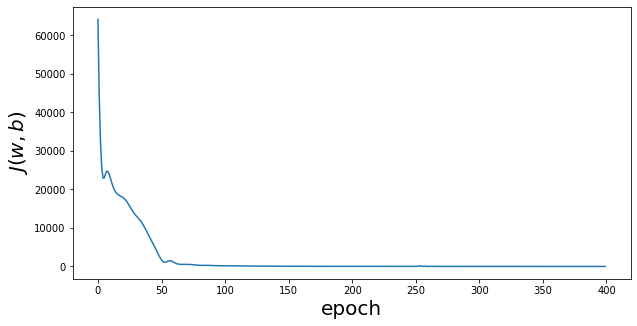

In [17]:
# show loss function change
plt.figure(figsize = (10,5))
plt.plot(losses)
plt.xlabel("epoch", size = 20)
plt.ylabel("$J(w,b)$", size = 20)

plt.show()

## Evaluar la capacidad de la Red para hacer predicciones usando los datos de validación

In [18]:
# VAMOS A COMPROBAR QUE LA RED FUNCIONÓ
_, x_pred_validate = odeint(lambda t, x: net(
    x), x0_validate, t_span_validate, solver='euler'
) # predicción con la red ya entrenada, pero usando nuevos datos que la red no ha visto
# varias condiciones iniciales

In [19]:
# convertir a array de numpy
x_pred_validate = x_pred_validate.detach().numpy()
type(x_pred_validate)

numpy.ndarray

Validación 1


<ipython-input-28-444fdf35470b>:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-28-444fdf35470b>:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-28-444fdf35470b>:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

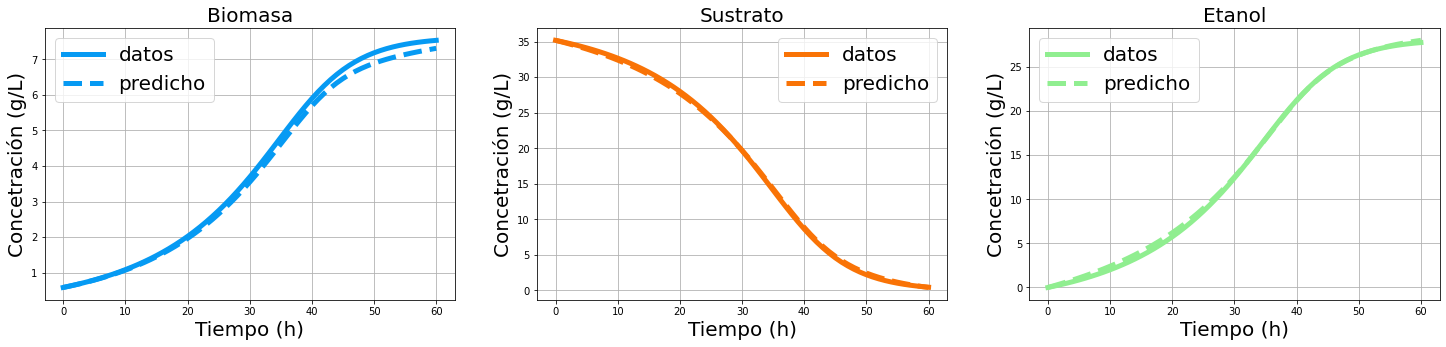

In [28]:
# for i in range(x_validate.shape[1]):
i = 0
print("Validación", i+1)
plt.figure(figsize = (25,5))

# la biomasa (0)
plt.subplot(131)
plt.plot(t_span_validate, 
    x_validate[..., i, 0], # lo real
    color="#069AF3", label = 'datos', linewidth = 5)

# el sustrato (1)
plt.subplot(132)
plt.plot(
    t_span_validate, 
    x_validate[..., i, 1], # lo real
    color="#F97306", label = 'datos', linewidth = 5)
# el producto (2)
plt.subplot(133)
plt.plot(t_span_validate, 
        x_validate[..., 0, 2], # lo real
        color="lightgreen", label = 'datos', linewidth = 5)

##### datos predichos ######
plt.subplot(131)
plt.plot(
    t_span_validate,
    x_pred_validate[..., i, 0], label = 'predicho', # lo predicho
    linestyle="dashed",
    color="#069AF3", linewidth = 5)
plt.grid()
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.title("Biomasa", size = 20)
plt.legend(fontsize = 20)


plt.subplot(132)
plt.plot(
    t_span_validate,
    x_pred_validate[..., i, 1], label = 'predicho', # lo predicho
    linestyle="dashed",
    color='#F97306', linewidth = 5)
plt.grid()
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.title("Sustrato", size = 20)
plt.legend(fontsize = 20)


plt.subplot(133)
plt.plot(
    t_span_validate,
    x_pred_validate[..., i, 2], label = 'predicho', # lo predicho
    linestyle="dashed",
    color="lightgreen", linewidth = 5)

plt.grid()
plt.xlabel("Tiempo (h)", size = 20)
plt.ylabel("Concetración (g/L)", size = 20)
plt.title("Etanol", size = 20)
plt.legend(fontsize = 20)
plt.show()

    